In [12]:
# Example on how to explain a single class for a ResNet50 model from pytorch modelzoo
# This example uses layer3.5 of the model
# Includes running the prediction test for the explanation
# The example is for class 430 (basketball), but can be run for any of the other 1000 classes as well,
# by changing class_to_explain in the cell below to some other class and rerun

In [13]:
class_to_explain = 430

In [ ]:
# load the resnet50 model from pytorch model zoo

from torchvision.models import resnet50
from core.config import DEVICE

DATA_PATH = "data_for_example"

model = resnet50(pretrained=True).to(DEVICE).eval()
layer = model.layer3[5] # we need to manually choose a layer of the model, here we use one that is fairly deep into the model

model_name = "resnet50"
layer_name = "_layer3[5]"


In [15]:
# this cell would only need to be run once, changing the class_to_explain does not require to re-run this
# cause here we simply generate the dictionary of concepts from all the imagenet val data, we only need to do this once

from torch.utils.data import DataLoader
# load the imagenet val dataset, we extract the crops for visualizing the concepts from this dataset
from core.imagenet_utils import get_dataset
from example_generate_basis_visualization_from_data_imagenet import sample_closest_image_patches, generate_data_including_prediction

# need to set the PATH_TO_IMAGENET_VAL variable inside core/config.py, so .../imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/
dataset = get_dataset(use_train_ds=False)
dataloader = DataLoader(dataset, shuffle=False, batch_size=128, num_workers=8)

# same params as in the paper, the activations are extracted at the layer and are then run through an average pooling with stride 2 and kernel size 2
activations_all, prediction_classes = generate_data_including_prediction(model, layer, dataloader, kernel_size=2, stride=2, use_average_pooling=True)
prediction_classes = prediction_classes.cpu().numpy()


100%|##########| 391/391 [01:56<00:00,  3.35it/s]


all activations shape: torch.Size([50000, 1024, 7, 7])


In [16]:
import torch
import torch.nn.functional as F
import os
import torchvision
import numpy as np


def get_concept_patches(concept_activation_vectors, activations, image_dataset, is_image_dataset_list=True, n_to_sample=1):
    all_concept_patches = []
    full_images = []
    for component_index in range(len(concept_activation_vectors)):
        concept_patches, full_imgs = sample_closest_image_patches(concept_activation_vectors[component_index], activations, image_dataset, n_to_sample=n_to_sample, is_image_dataset_list=is_image_dataset_list,
                                                                  return_full_imgs_as_well=True)
        all_concept_patches.append(concept_patches)
        full_images.append(full_imgs)

    return torch.cat(all_concept_patches, dim=2), torch.cat(full_images, dim=0)


def get_concept_patches_for_class(class_idx, exclude_target_class_from_patches=False, n_to_sample=1):
    # those nmf basis vectors are precomputed, there are six of them each one representing one concept the model uses to predict the class
    # precomputing them for all 1000 classes takes a bit under a day on a single RTX 2080Ti
    data_path = os.path.join("data_for_example", model_name + layer_name, str(class_idx), "nmf", "nmf_basis.pt")
    concept_activation_vectors = torch.load(data_path).to(DEVICE)

    # returns both the normalized images used in get_concept_patches, but finally returns the unnormalized images for plotting
    unnormalized_img_dataset = get_dataset(return_original_sample=True, use_train_ds=False)

    if exclude_target_class_from_patches:
        indices = np.where(prediction_classes != class_idx)[0]
        image_dataset = torch.utils.data.Subset(unnormalized_img_dataset, indices)
        activations = activations_all[indices]
    else:
        image_dataset = unnormalized_img_dataset
        activations = activations_all

    unnormalized_concept_patches, full_imgs = get_concept_patches(concept_activation_vectors, activations, image_dataset, is_image_dataset_list=False, n_to_sample=n_to_sample)

    return unnormalized_concept_patches, full_imgs


def run_prediction_for_concept_patches(class_idx, concept_patches):

    with torch.no_grad():
        pred = F.softmax(model(concept_patches.to(DEVICE)), dim=1)
        pred_class = torch.mean(pred[:, class_idx])
        max_class = torch.argmax(torch.mean(pred, dim=0))
        max_pred = torch.max(torch.mean(pred, dim=0))

        print("class idx: {}".format(class_idx))
        print("pred class: {}, max_class: {}, max_pred: {}".format(pred_class, max_class, max_pred))



In [17]:
# the predictions reported in the paper, for each of the 1000 classes; exluding images where the model predicts the class_to_explain when sampling the concept patches
# not used in the rest of this notebook, can be used to find classes where the prediction test works (only works for 30% of the classes)
file_path = os.path.join("data_for_example", "concept_pred_test", model_name + layer_name, "nmf_comp_check_exclude_target_predictions_for_class.pt")
predictions_list = torch.load(file_path)

for class_idx, pred in enumerate(predictions_list):
    if pred > 0.5:
        print(class_idx, pred)
        # imagenet class, prediction for the explanation of that class

3 tensor(0.8924, device='cuda:0')
7 tensor(0.9922, device='cuda:0')
10 tensor(0.6545, device='cuda:0')
11 tensor(1.0000, device='cuda:0')
12 tensor(0.9962, device='cuda:0')
18 tensor(0.5742, device='cuda:0')
21 tensor(0.8217, device='cuda:0')
28 tensor(0.9994, device='cuda:0')
30 tensor(0.9167, device='cuda:0')
31 tensor(0.8927, device='cuda:0')
35 tensor(0.8013, device='cuda:0')
37 tensor(0.9991, device='cuda:0')
41 tensor(0.7311, device='cuda:0')
45 tensor(1.0000, device='cuda:0')
56 tensor(1.0000, device='cuda:0')
63 tensor(0.8020, device='cuda:0')
64 tensor(0.9985, device='cuda:0')
67 tensor(0.9432, device='cuda:0')
72 tensor(0.9918, device='cuda:0')
83 tensor(0.9522, device='cuda:0')
85 tensor(0.9413, device='cuda:0')
87 tensor(0.5153, device='cuda:0')
89 tensor(0.9993, device='cuda:0')
90 tensor(0.9819, device='cuda:0')
93 tensor(0.9941, device='cuda:0')
97 tensor(0.6465, device='cuda:0')
101 tensor(0.8608, device='cuda:0')
104 tensor(0.5378, device='cuda:0')
122 tensor(0.9998, d

class idx: 430
pred class: 0.9999887943267822, max_class: 430, max_pred: 0.9999887943267822
torch.Size([1, 3, 192, 32])


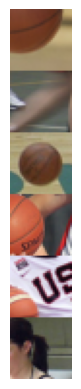

In [18]:
import matplotlib.pyplot as plt

# generate n_to_sample=8 examples per concept. Allow to sample patches from class_to_explain (the class we wish to explain)
unnormalized_concept_patches, _ = get_concept_patches_for_class(class_idx=class_to_explain, n_to_sample=8, exclude_target_class_from_patches=False)

# only use the first example
normalized_concept_patches = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(unnormalized_concept_patches[0].unsqueeze(dim=0))

run_prediction_for_concept_patches(class_to_explain, normalized_concept_patches)
print(normalized_concept_patches.shape) # 1, 3, 192, 32 -> each concept example has a size of 32x32

plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu()[0].permute(1, 2, 0))

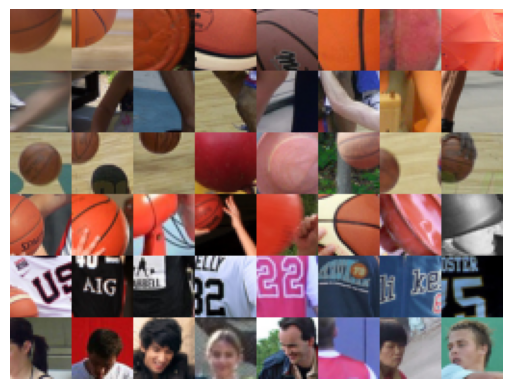

In [19]:
import matplotlib.pyplot as plt

# plot all 8 examples
unnormalized_concept_patches = torch.cat([unnormalized_concept_patches[i] for i in range(len(unnormalized_concept_patches))], dim=-1)
plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu().permute(1, 2, 0))

# the first concept looks like part of a basketball, the second one look like legs, the third looks like basketball again,
# the fourth like a basketball held in hands, the fifth looks like trikots, and the last looks like faces

class idx: 430
for full images: pred class: tensor([5.8158e-08, 1.5980e-05, 6.0666e-04, 7.1184e-04, 3.5561e-07, 2.8774e-09,
        6.3477e-04, 1.2224e-03, 8.2626e-07, 7.2241e-05, 1.4824e-04, 1.2897e-07,
        9.3206e-07, 1.1707e-02, 3.7925e-05, 1.9242e-05, 2.2421e-05, 3.5561e-07,
        4.9858e-06, 2.9235e-03, 7.8179e-07, 2.5452e-07, 4.9760e-07, 2.4110e-11,
        1.3673e-07, 4.6725e-03, 1.0091e-04, 7.1386e-09, 2.9346e-04, 1.1770e-05,
        2.3772e-06, 5.3560e-08, 1.0178e-05, 1.1367e-06, 3.2078e-03, 3.1432e-04,
        1.8682e-08, 7.8726e-09, 5.3300e-03, 1.8053e-09, 5.1654e-06, 3.0116e-04,
        9.3906e-06, 5.0320e-07, 3.6349e-06, 3.4943e-09, 8.4357e-04, 1.3761e-11],
       device='cuda:0'), max_class: tensor([866, 203, 285, 879, 808, 105, 546, 768, 575, 929, 655, 786, 444, 655,
        890, 602, 989, 808, 990, 369, 422, 398, 706, 592, 545, 747, 731, 744,
        830, 641, 820, 805, 422, 981, 501, 752, 560, 981, 890, 428, 639, 752,
        982, 702, 872, 909, 752, 704], device

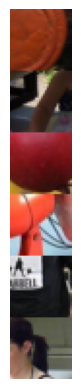

In [20]:
# same as above, but now do not allow to sample the concept patches from dataset images where the model predicts the class we wish to explain
# (i.e. only sample from images where the model does not predict class_to_explain)
# this works a bit worse compared to allowing the class we wish to explain, but makes a stronger point if it works

import matplotlib.pyplot as plt

# generate n_to_sample=8 examples per concept. Only sample the patches from images where the model is not predicting class_to_explain
unnormalized_concept_patches, full_imgs = get_concept_patches_for_class(class_idx=class_to_explain, n_to_sample=8, exclude_target_class_from_patches=True)

normalized_imgs = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(full_imgs)

with torch.no_grad():
    pred = F.softmax(model(normalized_imgs.to(DEVICE)), dim=1)
    pred_class = pred[:, class_to_explain]
    max_class = torch.argmax(pred, dim=1)

    print("class idx: {}".format(class_to_explain))
    print("for full images: pred class: {}, max_class: {}".format(pred_class, max_class)) # double check that the model does not predict class_to_explain as majority class for any of the full images, just to be sure...

# only use the first example
normalized_concept_patches = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(unnormalized_concept_patches[0].unsqueeze(dim=0))
run_prediction_for_concept_patches(class_to_explain, normalized_concept_patches) # here we now want it to predict class_to_explain, since we pass it the image combined from the crops

plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu()[0].permute(1, 2, 0))

# here the model now predicts basketball with only 0.12, the majority class is 747 (punching bag) with 0.75, this would count as failed
# since basketball is not the majority class

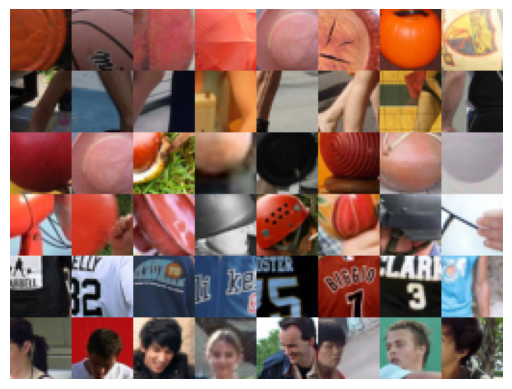

In [21]:
import matplotlib.pyplot as plt

# plot all 8 examples

unnormalized_concept_patches = torch.cat([unnormalized_concept_patches[i] for i in range(len(unnormalized_concept_patches))], dim=-1)
plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu().permute(1, 2, 0))

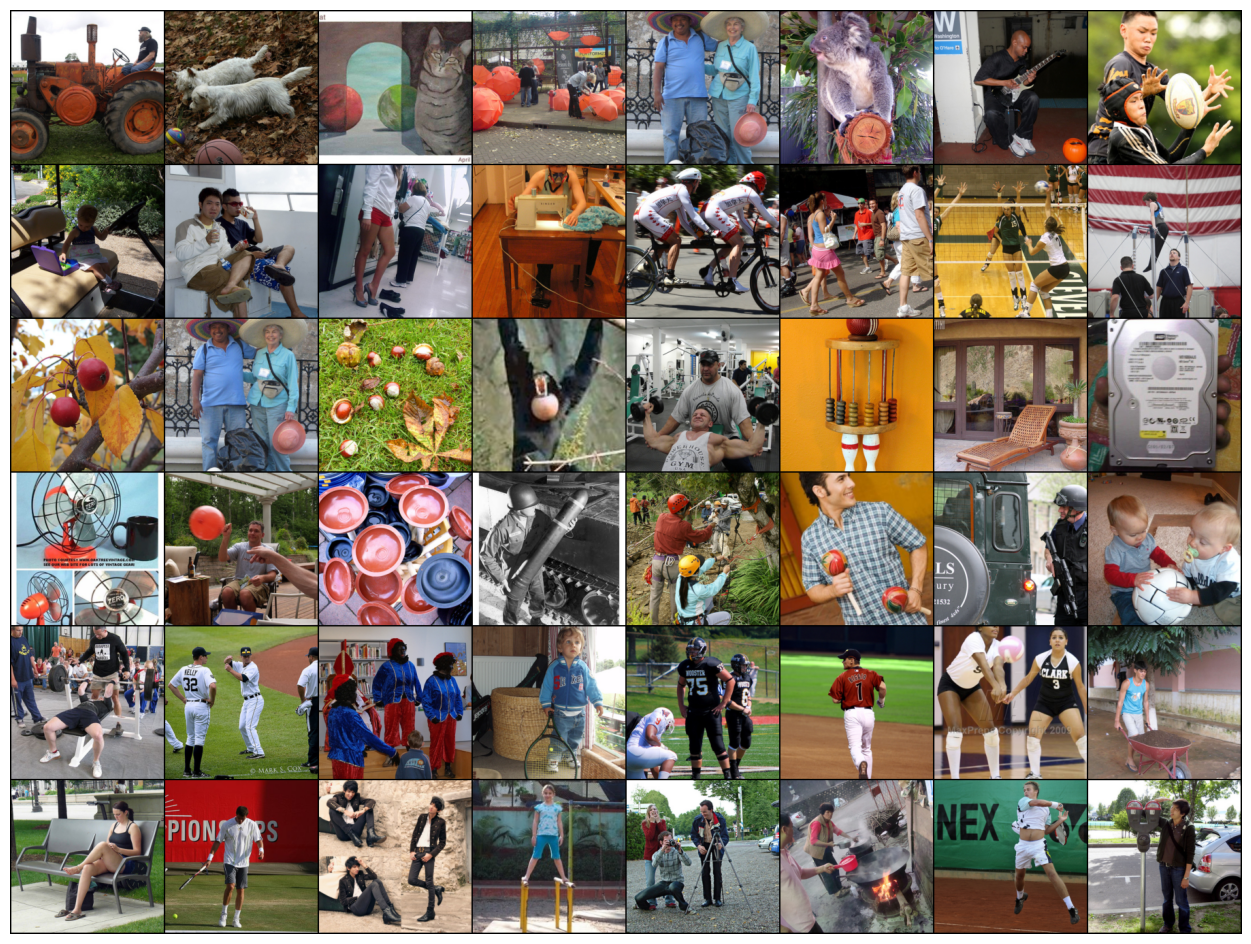

In [22]:
# show the full images where the patches above are extracted from (each patch is extracted from the corresponding image,
# i.e. we have an image grid with grid width of 8 and height of 6 so e.g. the patch in the above image at position (2, 3)
# would come somewhere from the image below that is at position (2, 3) in the grid below)
# note that while the model does not predict the class_to_explain class as majority class for any of them,
# class_to_explain may be the actual ground truth class (we only filter by the model's prediction and ignore the actual ground truth,
# since we want to explain the behavior of the model and not the labeling)

img_grid = torchvision.utils.make_grid(full_imgs)

fig = plt.figure(figsize=(16, 12))

plt.axis('off')
plt.imshow(img_grid.cpu().permute(1, 2, 0))